In [14]:
!pip install -U pandas matplotlib seaborn scikit-learn xgboost tensorflow imbalanced-learn

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [16]:
from google.colab import files
uploaded = files.upload()

Saving audit_data.csv to audit_data (1).csv


In [18]:
df = pd.read_csv('/content/audit_data.csv')

In [19]:
print("Dataset Information:")
print(df.info())
print("\nFirst few rows of the dataset:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Transaction_ID  10000 non-null  int64  
 1   Amount          10000 non-null  float64
 2   Type            10000 non-null  object 
 3   Merchant        10000 non-null  object 
 4   Location        10000 non-null  object 
 5   Time            10000 non-null  int64  
 6   Day_of_Week     10000 non-null  object 
 7   Account_Type    10000 non-null  object 
 8   Fraudulent      10000 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 703.2+ KB
None

First few rows of the dataset:
   Transaction_ID      Amount    Type Merchant       Location  Time  \
0               1  380.794718  Credit  Walmart          Local    14   
1               2  951.207163   Debit   Amazon  International    14   
2               3  734.674002   Debit   Amazon  International  

In [20]:
label_encoders = {}
for column in ['Type', 'Merchant', 'Location', 'Day_of_Week', 'Account_Type']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print("Categorical variables encoded.")

Categorical variables encoded.


In [21]:
scaler = StandardScaler()
df[['Amount', 'Time']] = scaler.fit_transform(df[['Amount', 'Time']])
print("Numerical features scaled.")

Numerical features scaled.


In [22]:
X = df.drop(columns=['Transaction_ID', 'Fraudulent'])
y = df['Fraudulent']

In [23]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [25]:
def evaluate_model(model, X_test, y_test, is_nn=False):
    if is_nn:
        # Deep learning model
        y_proba = model.predict(X_test)
        y_pred = (y_proba > 0.5).astype("int32")
    else:
        # Traditional models
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

    print(f"\n{model.__class__.__name__} Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\n{model.__class__.__name__} Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.show()

    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{model.__class__.__name__} ROC AUC Score: {auc:.4f}")



RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1931
           1       0.90      0.94      0.92      1882

    accuracy                           0.92      3813
   macro avg       0.92      0.92      0.92      3813
weighted avg       0.92      0.92      0.92      3813


RandomForestClassifier Confusion Matrix:


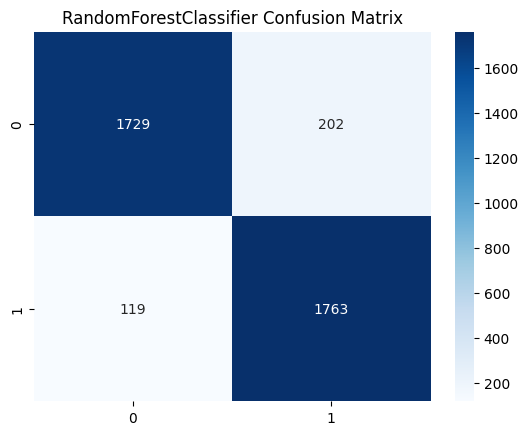


RandomForestClassifier ROC AUC Score: 0.9715

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62      1931
           1       0.62      0.72      0.66      1882

    accuracy                           0.64      3813
   macro avg       0.65      0.64      0.64      3813
weighted avg       0.65      0.64      0.64      3813


SVC Confusion Matrix:


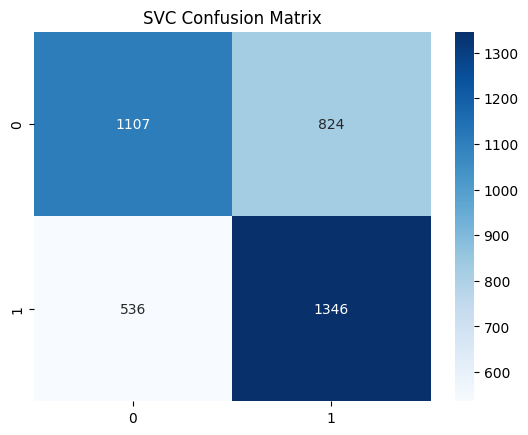


SVC ROC AUC Score: 0.6786

GradientBoostingClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1931
           1       0.88      0.83      0.85      1882

    accuracy                           0.86      3813
   macro avg       0.86      0.86      0.86      3813
weighted avg       0.86      0.86      0.86      3813


GradientBoostingClassifier Confusion Matrix:


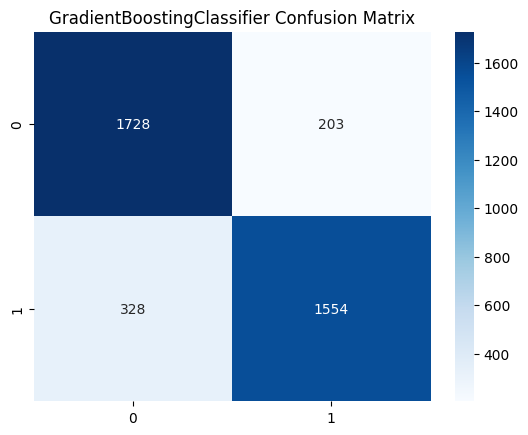


GradientBoostingClassifier ROC AUC Score: 0.9271

XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1931
           1       0.95      0.88      0.91      1882

    accuracy                           0.92      3813
   macro avg       0.92      0.92      0.92      3813
weighted avg       0.92      0.92      0.92      3813


XGBClassifier Confusion Matrix:


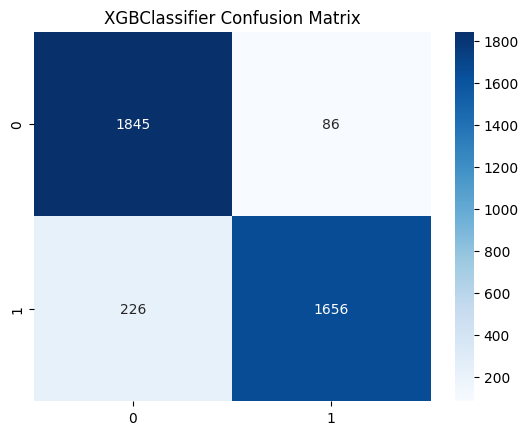


XGBClassifier ROC AUC Score: 0.9659


In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(probability=True, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(scale_pos_weight=len(y_train) / (2 * sum(y_train)), eval_metric='logloss', random_state=42)

for model in [rf, svm, gb, xgb]:
    model.fit(X_train, y_train)
    evaluate_model(model, X_test, y_test)

In [46]:
def create_nn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))  # INPUT SHAPE SET HERE
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [48]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: 1.0032236842105262, 1: 0.9967969669237808}


In [49]:
print("Class weights dictionary:")
print(class_weights_dict)

Class weights dictionary:
{0: 1.0032236842105262, 1: 0.9967969669237808}


In [50]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [51]:
nn_model = create_nn_model(X_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
try:
    history = nn_model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        class_weight={0: class_weights_dict[0], 1: class_weights_dict[1]}  # UPDATED CLASS WEIGHTS FORMAT
    )
except Exception as e:
    print(f"Error during training: {e}")

Epoch 1/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5189 - loss: 0.7467 - val_accuracy: 0.5282 - val_loss: 0.6920
Epoch 2/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5236 - loss: 0.6948 - val_accuracy: 0.5374 - val_loss: 0.6895
Epoch 3/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5499 - loss: 0.6879 - val_accuracy: 0.5561 - val_loss: 0.6841
Epoch 4/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5566 - loss: 0.6842 - val_accuracy: 0.5774 - val_loss: 0.6792
Epoch 5/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5618 - loss: 0.6822 - val_accuracy: 0.5793 - val_loss: 0.6782
Epoch 6/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5735 - loss: 0.6787 - val_accuracy: 0.5718 - val_loss: 0.6772
Epoch 7/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5709 - loss: 0.6769 - val_accuracy: 0.5852 - val_loss: 0.6729
Epoch 8/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5859 - loss: 0.6712 - val_accuracy: 0.

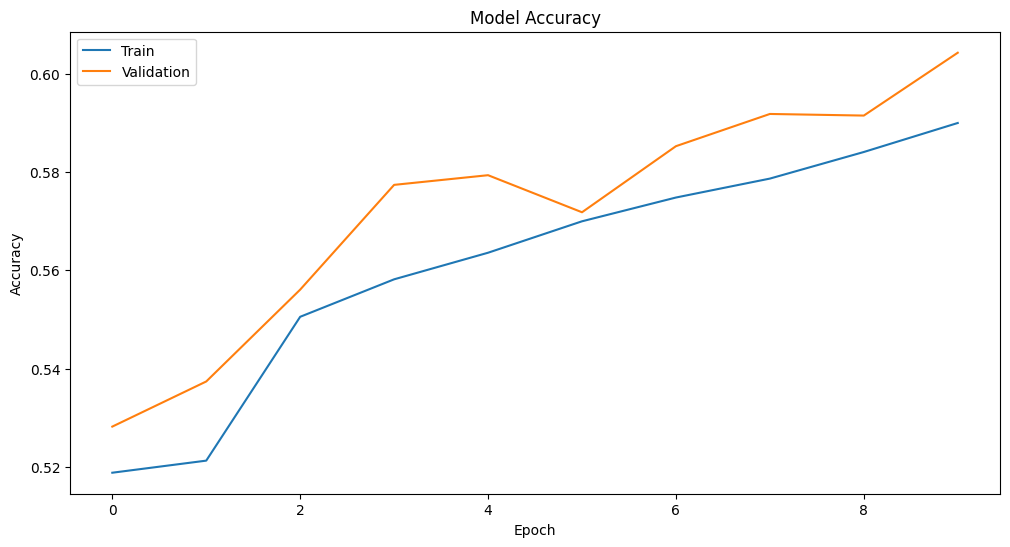

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Sequential Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      1931
           1       0.58      0.69      0.63      1882

    accuracy                           0.60      3813
   macro avg       0.61      0.61      0.60      3813
weighted avg       0.61      0.60      0.60      3813


Sequential Confusion Matrix:


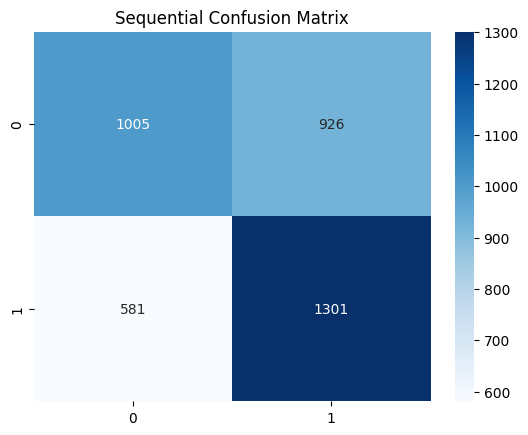


Sequential ROC AUC Score: 0.6323


In [54]:
evaluate_model(nn_model, X_test, y_test, is_nn=True)

In [55]:
def evaluate_model_nn(model, X_test, y_test):
  y_proba = model.predict(X_test)
  y_pred = (y_proba > 0.5).astype("int32")

  print(f"\n{model.__class__.__name__} Classification Report:")
  print(classification_report(y_test, y_pred))

  print(f"\n{model.__class__.__name__} Confusion Matrix:")
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'{model.__class__.__name__} Confusion Matrix')
  plt.show()

  auc = roc_auc_score(y_test, y_proba)
  print(f"\n{model.__class__.__name__} ROC AUC Score: {auc:.4f}")

120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Sequential Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      1931
           1       0.58      0.69      0.63      1882

    accuracy                           0.60      3813
   macro avg       0.61      0.61      0.60      3813
weighted avg       0.61      0.60      0.60      3813


Sequential Confusion Matrix:


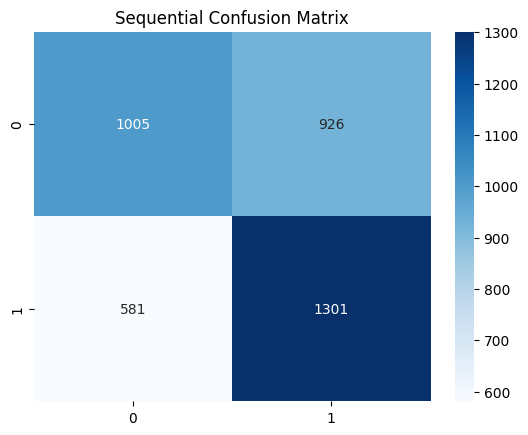


Sequential ROC AUC Score: 0.6323


In [56]:
evaluate_model_nn(nn_model, X_test, y_test)